In [1]:
import numpy as np
import scipy.stats as scs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest, chi2

from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
pd.options.display.max_columns = None # Show all columns
pd.options.display.max_rows = None # Show all columns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
data = pd.read_csv('data.csv')
data.head()

,group,age,sex,education,profession,income,companion,selfcare,children,intimacy
0,0,1,2,3,1,4,3,4,2,4
1,0,1,2,3,5,5,5,4,2,4
2,0,1,2,5,1,5,3,4,2,4
3,1,1,2,5,4,4,3,4,2,4
4,1,1,2,5,5,5,3,4,1,4


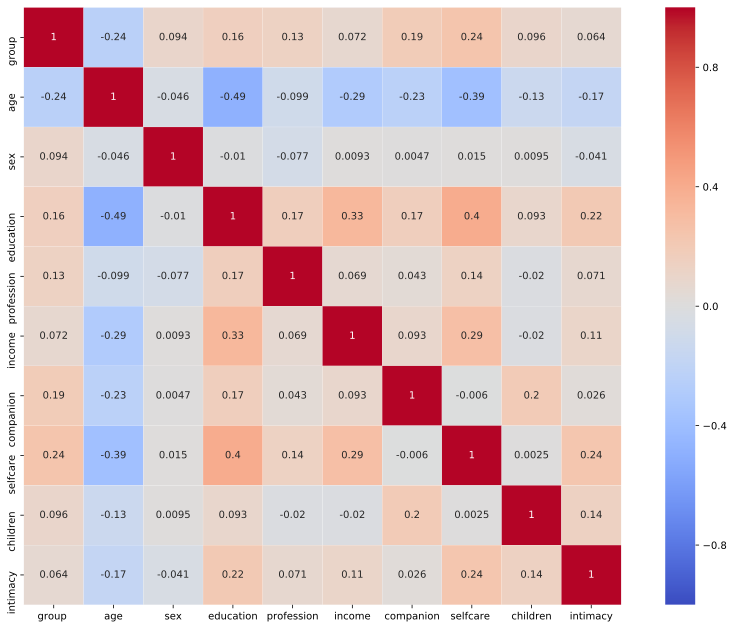

In [3]:
plt.figure(figsize=(16, 11))

sns.heatmap(data.astype(float).corr(method='kendall'), linewidths=0.1, square=True,
            cmap='coolwarm', linecolor='white', annot=True, vmax=1, vmin=-1);

# plt.savefig('heatmap.svg')

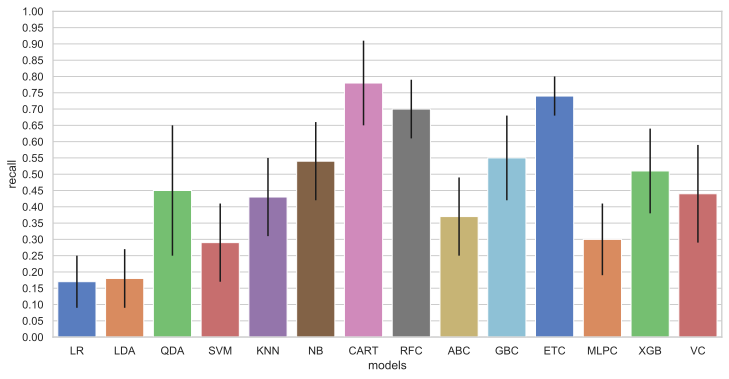

In [4]:
seed = 1

X, y = data.values[:,1:], data.values[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

models = {
    'LR'  : LogisticRegression(),
    'LDA' : LinearDiscriminantAnalysis(),
    'QDA' : QuadraticDiscriminantAnalysis(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'NB'  : GaussianNB(),
    'CART': DecisionTreeClassifier(random_state=seed),
    'RFC' : RandomForestClassifier(random_state=seed),
    'ABC' : AdaBoostClassifier(),
    'GBC' : GradientBoostingClassifier(random_state=seed),
    'ETC' : ExtraTreesClassifier(random_state=seed),
    'MLPC': MLPClassifier(random_state=seed),
    'XGB' : XGBClassifier()
}

models['VC'] = VotingClassifier(estimators=[
    ('lr', models['LR']), ('lda', models['LDA']), ('qda', models['QDA']),
    ('svm', models['SVM']),('knn', models['KNN']), ('nb', models['NB']), 
    ('cart', models['CART']), ('rfc', models['RFC']), ('abc', models['ABC']),
    ('gbc', models['GBC']), ('etc', models['ETC']), ('mlpc', models['MLPC']),
    ('xgb', models['XGB'])], voting='hard')

kfold = StratifiedKFold(n_splits=10, random_state=seed)

cv_results = []

for key in models:
        cv_score = cross_val_score(models[key], X_train, y_train, scoring="recall", cv=kfold)
        cv_mean = round(cv_score.mean(), 2)
        cv_std = round(cv_score.std(), 2)
        cv_result = {'models': key, 'recall': cv_mean, 'cv_std': cv_std}
        cv_results.append(cv_result)

cv_results = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
cv_plot = sns.barplot(x='models', y='recall', data=cv_results, palette="muted",  **{'yerr': cv_results['cv_std']});
cv_plot.set_yticks(np.arange(0, 1.05, 0.05));
# plt.savefig('modelselection.svg')

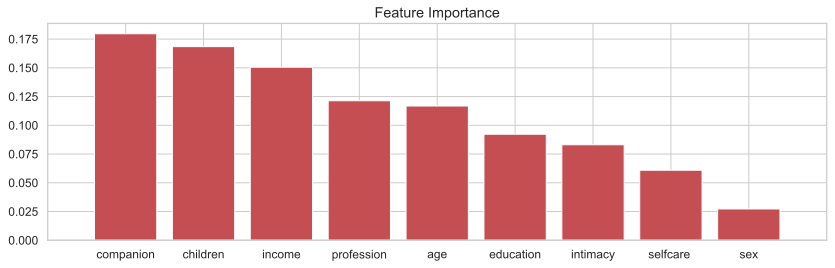

In [5]:
models['CART'].fit(X_train, y_train)
skplt.estimators.plot_feature_importances(models['CART'], feature_names=data.columns[1:], figsize=(14, 4));
# plt.savefig('feature.svg')

In [6]:
parameters = {
                'max_depth': range(1,100),
                'max_features': range(1,13)
}

grid_obj = GridSearchCV(models['CART'], param_grid=parameters, scoring='recall', cv=kfold)

grid_fit = grid_obj.fit(X_train, y_train)

best_estimator = grid_fit.best_estimator_

best_estimator.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

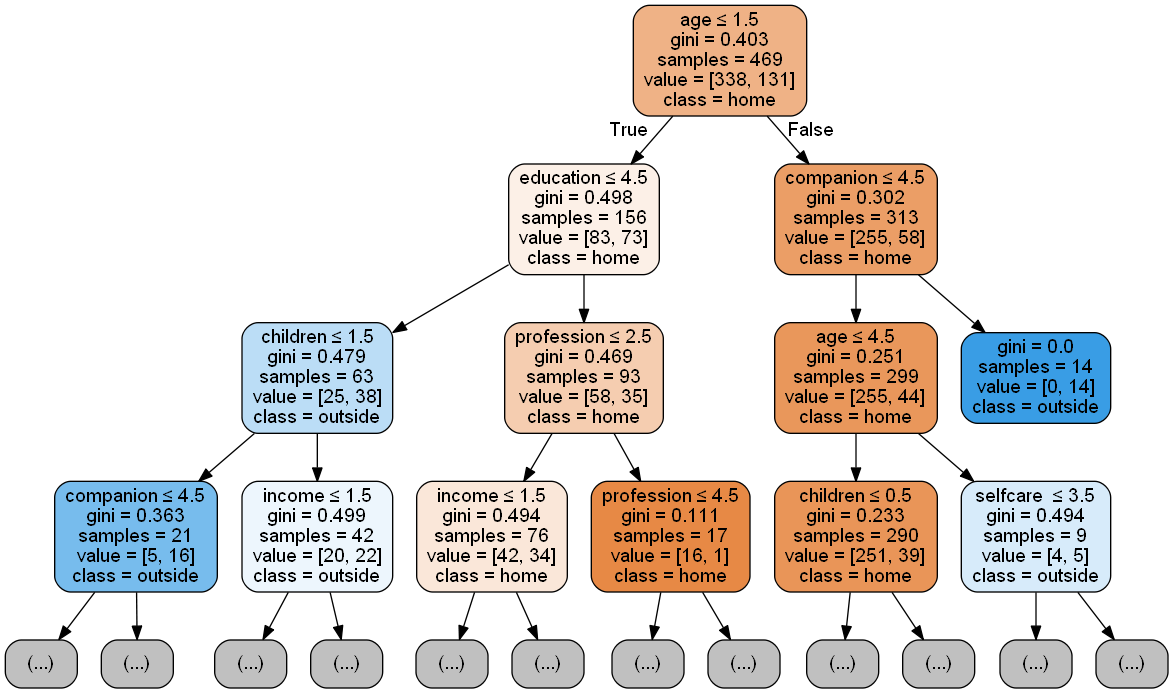

In [7]:
from IPython.display import Image  
import pydotplus
dot_data = tree.export_graphviz(best_estimator, out_file=None, 
                         feature_names=data.columns[1:],  
                         class_names=['home','outside'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
# graph.write_svg('tree.svg')

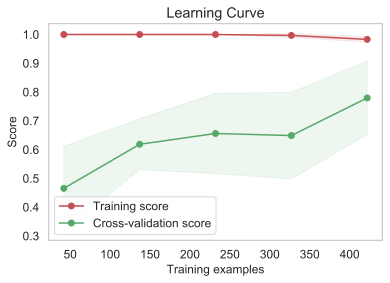

In [8]:
skplt.estimators.plot_learning_curve(best_estimator, X_train, y_train, cv=kfold, scoring='recall');
# plt.savefig('learncurve.svg')

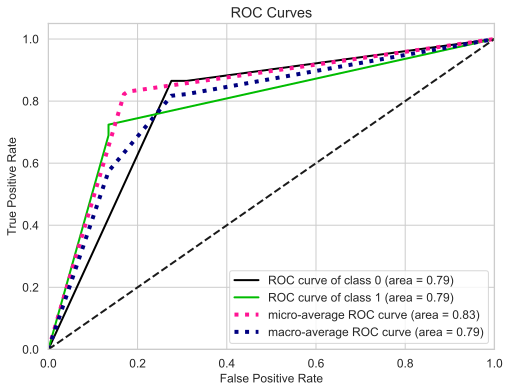

In [9]:
predicted_probas = best_estimator.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas,title='ROC Curves', plot_micro=True, plot_macro=True, classes_to_plot=[0,1], ax=None, figsize=(8,6), title_fontsize='large', text_fontsize='medium');
# plt.savefig('roc.svg')

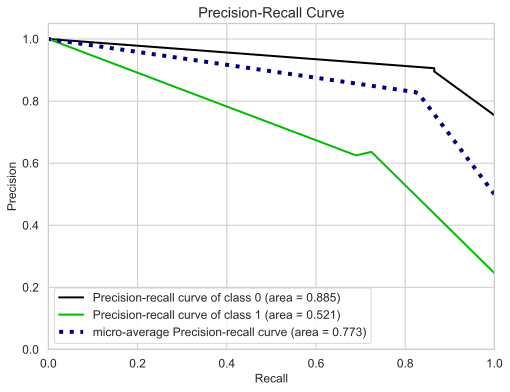

In [10]:
y_probas = best_estimator.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(8,6));
# plt.savefig('prcurve.svg')

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        89
           1       0.62      0.69      0.66        29

    accuracy                           0.82       118
   macro avg       0.76      0.78      0.77       118
weighted avg       0.83      0.82      0.82       118



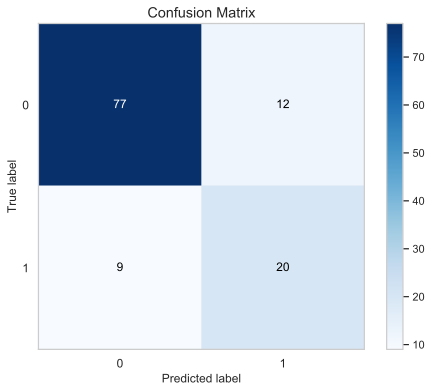

In [11]:
y_pred = best_estimator.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(8,6))
# plt.savefig('confusionmatrix.svg')
print(classification_report(y_test, y_pred))